# Spark Architecture
- Spark is built on Java/Scala, so in order to use Python with it we need an intermediate layer - this layer is JVM (Java Virtual machine)
- A Spark application has 3 key Components
- 1. Driver Node: One of the nodes in the cluster, which distributes the tasks amongst the workers
  2. Worker Node: This is where actual computations happens; Within them you have **Executors** which execute tasks assigned by the driver 
  3. Cluster Manager: This particular component can be standalone; It's main job is to allocate resources across applications and manage the worker nodes

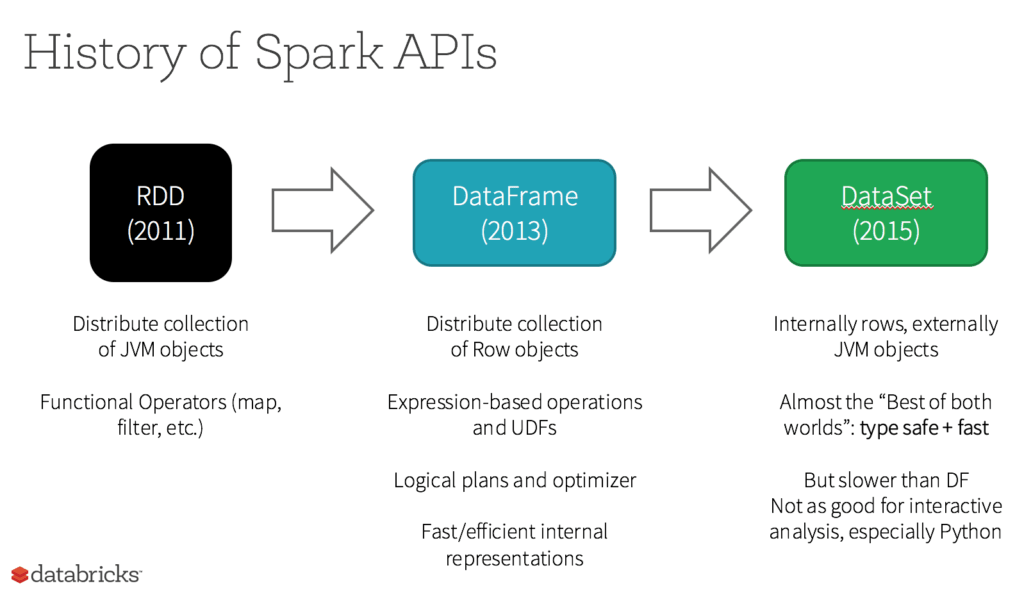

# SparkContext
- it's the main entry point for Spark functionality
- Using this you can submit your spark jobs
- SparkContext also acts as cluster manager and resource manager

# SparkSession
- entry point to Spark with DataFrame and Dataset API

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("spark_fundamentals").getOrCreate()
print("Spark Session initialised")

Spark Session initialised


# Spark APIs
https://www.databricks.com/glossary/spark-api

## 1. RDD (Resilient Distributed Dataset)

https://spark.apache.org/docs/latest/rdd-programming-guide.html

- Fundamental data structure in Spark
- Resilient means it can automatically recover from node failure
- Distributed as the name suggests shows that the data is stored across various nodes
- Data is stored in-memory (RAM) for faster execution
- Supports transformations(map, filter, reduceByKey) and actions (apply computation - collect, count)
- It is immutable (cannot alter after creation) and can be operated parallely

### Ways to Create a RDD
1. Using SparkContext's parallelize method on an iterable
2. Any storage sources that support Hadoop (AWS S3, HDFS, Cassandra..), Spark can create an RDD from it
3. A copy of another RDD

### RDD Operations
- **Transformations**: These are the operations which result into a new RDD
- **Actions**: Returns value to the driver program after computation

### Disadvantages of RDDs
1. RDDs do not infer the schema, you need to specify it manually
2. Need to optimize each and every RDD
   
#### Lazy Transformations
- One of the main features of Spark is that transformations are lazily evaulated
- This means that only when the results are needed (.show, .collect, count etc) only then are the transformations applied
- In this way Spark can create an execution plan (a DAG) which is optimized (apply the later transformations on the smaller data sets)

In [5]:
from pyspark.sql.functions import col
# Example of how Spark optimizes execution
data = spark.range(1000000)  # Create DataFrame with 1M rows
filtered = data.filter(col("id") < 100)  # Filter for small subset
mapped = filtered.select(col("id") * 2)  # Transform the data
result = mapped.count()  # Action that triggers execution
print(result)
# Spark will:
# 1. First apply the filter (reducing to 100 rows)
# 2. Then multiply only those 100 rows
# 3. Finally count them
# Instead of:
# 1. Multiplying all 1M rows
# 2. Then filtering them
# 3. Then counting

100


In [10]:
# Original code
data = [('A','1','20','10000','Engineering'),
       ('B','2','31','11000','HR'),
       ('C','3','30','12000','Engineering')]

headers = ['employee_name','employee_id','age','salary','department']

df = spark.createDataFrame(data,headers)

filtered1 = df.filter(col("age") > 25)
transformed = filtered1.withColumn("salary_doubled", col("salary") * 2)
filtered2 = transformed.filter(col("department") == "Engineering")

filtered2.explain(True)
# What Spark might actually do:
# 1. Combine both filters (age > 25 AND department == "Engineering")
# 2. Apply filters first
# 3. Then do the salary calculation only on filtered rows

== Parsed Logical Plan ==
'Filter ('department = Engineering)
+- Project [employee_name#68, employee_id#69, age#70, salary#71, department#72, (cast(salary#71 as double) * cast(2 as double)) AS salary_doubled#78]
   +- Filter (cast(age#70 as int) > 25)
      +- LogicalRDD [employee_name#68, employee_id#69, age#70, salary#71, department#72], false

== Analyzed Logical Plan ==
employee_name: string, employee_id: string, age: string, salary: string, department: string, salary_doubled: double
Filter (department#72 = Engineering)
+- Project [employee_name#68, employee_id#69, age#70, salary#71, department#72, (cast(salary#71 as double) * cast(2 as double)) AS salary_doubled#78]
   +- Filter (cast(age#70 as int) > 25)
      +- LogicalRDD [employee_name#68, employee_id#69, age#70, salary#71, department#72], false

== Optimized Logical Plan ==
Project [employee_name#68, employee_id#69, age#70, salary#71, department#72, (cast(salary#71 as double) * 2.0) AS salary_doubled#78]
+- Filter ((isnotnull

## 2. DataFrame API

- Distributed collection of data organised into named columns like a table in RDB
- It is immutable
- Built on top of RDD API to cater to a wider audience
- Optimized for large data processing

## 3. Dataset API
- Combines features of RDD and DataFrame
- It is Type Safe  means that it can detect semantic errors during compilation itself


| Feature/Aspect | RDD (Resilient Distributed Dataset) | DataFrame | Dataset |
|----------------|-------------------------------------|-----------|----------|
| Definition | Low-level fundamental data abstraction representing distributed collection of elements | Distributed collection of data organized into named columns, like a database table | Strongly-typed version of DataFrame that combines RDD and DataFrame features |
| Type Safety | Complete compile-time type safety | No compile-time type safety, only runtime checks | Complete compile-time type safety |
| Schema | No schema requirement; works with unstructured data | Requires schema; auto-inferred or manually specified | Requires schema; combines type-safe objects with schema |
| Optimization | No built-in optimization; manual optimization required | Uses Catalyst Optimizer for automatic optimization | Uses Catalyst Optimizer while maintaining type safety |
| Language Support | All Spark-supported languages (Scala, Java, Python, R) | All Spark-supported languages | Only Scala and Java |
| Performance | Lower performance due to lack of optimization engine | Better performance due to Catalyst Optimizer | Similar to DataFrame, with slight overhead due to object creation |
| Use Cases | - Complex data types<br>- Custom partitioning<br>- Low-level control<br>- Legacy code maintenance | - Structured/semi-structured data<br>- SQL operations<br>- Machine learning<br>- Simple ETL tasks | - Complex ETL<br>- Domain objects<br>- When type safety is critical |
| Syntax Style | Functional programming (map, flatMap, filter) | SQL-like operations (select, where, groupBy) | Combination of both functional and SQL-like operations |
| Memory Usage | Less memory overhead (no schema) | Efficient memory usage due to schema | Higher memory usage due to object creation and JVM overhead |
| API Stability | Stable and mature API | Stable, actively developed | Newer API, still evolving |
| Ease of Use | More verbose, requires more code | Simple, intuitive SQL-like interface | Balance between type safety and ease of use |
| Data Format Support | Works with any data format, but requires manual parsing | Native support for structured formats (CSV, JSON, Parquet) | Same as DataFrame with added type safety |
| Error Detection | Compile-time errors for type mismatches | Runtime errors for schema violations | Compile-time errors for both type and schema violations |
| Serialization | Uses Java serialization by default | Custom encoders for efficient serialization | Custom encoders with type-safe serialization |** (not in Python).  |
 |
